In [46]:
#%matplotlib inline

In [47]:
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path
import netCDF4 as nc


import matplotlib.pylab as plt
#import seaborn as sns
import pymc3 as pm
from scipy import stats
import arviz as az
# if you get a ModuleNotFoundError,
# check if you did "pip install -e ." in the project root
import attrici.models as models
import attrici.fourier as fourier
import attrici.datahandler as dh
import attrici.estimator as est
import attrici.distributions as dist

import settings as s


plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = 12,8

print(pm.__version__)

3.7


## Load input data and define variable
Extract and plot cfactual data as a timeeries for a single pair of coordinates

In [49]:
data_dir = Path(".")
s.output_dir = Path(data_dir) / "output"

variable = "tas"

# get the predictor, a smoothed version of global mean temperature.
ncg = nc.Dataset("./test_input/GSWP3-W5E5/gswp3-w5e5_ssa_gmt.nc4","r")
gmt = np.squeeze(ncg.variables["tas"][:])

# get regional climate variable data, here surface air temperature "tas"
#ncf = nc.Dataset("./output_pr/cfact/pr/pr_GSWP3-W5E5_cfactual.nc4", "r")
ncf = nc.Dataset("./output/cfact/tas/tas_GSWP3-W5E5_cfactual.nc4", "r")
nct = ncf.variables["time"]

## Generate counterfactual timeseries for a coordinate pair

In [50]:
# Choose from one of the few grid cells in the sample datasets.
# lat 49.75, lon 20.25, a region in South Poland, south of Krakow
i=2
j=10
ncf.variables["lat"][i].data, ncf.variables["lon"][j].data

(array(49.75), array(20.25))

In [51]:
# read data and time into a specific dataframe that is understood by icounter.
data = ncf.variables["cfact"][:, i, j]

# dh.create_dataframe produces a calender and a scaled time axis and variables.
# this helps for efficient sampling
df, datamin, scale = dh.create_dataframe(nct[:],nct.units, data[:],
                                         gmt,variable)

# ncf.close()
# ncg.close()

In [52]:
t = pd.DataFrame(data[:], index=nct)
t.tail(3)

,0
time,
58436.0,267.183990
58437.0,269.811646
58438.0,274.322021


#### Plot for a first, quick insight

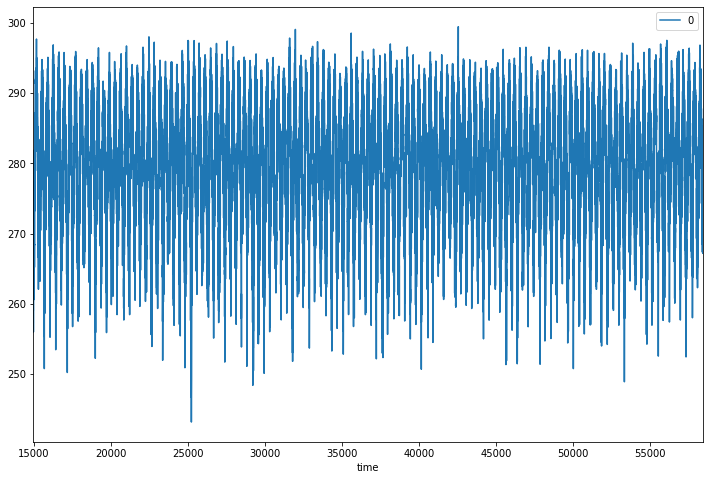

In [53]:
last_5_year_start = len(t)-5*365
t.loc[:].plot()

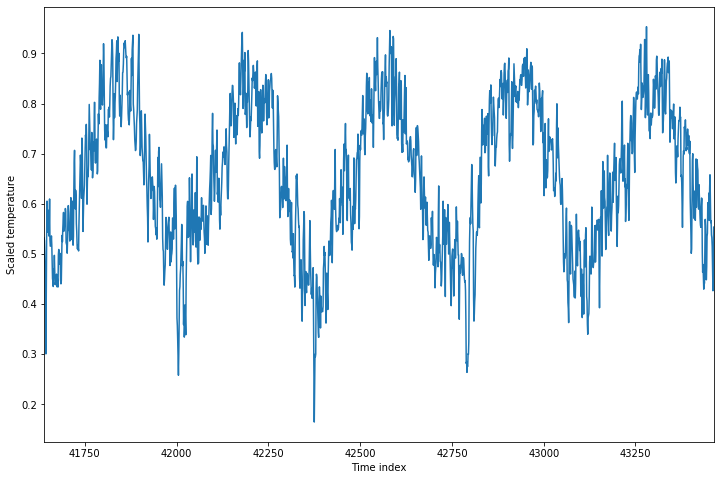

In [54]:
# the variable we would like to build a counterfactual of,
# in its scaled form, last 5 years only
last_5_year_start = len(df)-5*365
df.loc[last_5_year_start:,"y_scaled"].plot()
plt.ylabel("Scaled temperature")
l = plt.xlabel("Time index")

## Compair counterfactual and original data visually 
##### -- under development -- some functions/classes of models.py, datahandler.py, distrubtions.py, estimator.py need to be modified

In [69]:
df_valid.tail(3)

,ds,t,y,y_scaled,gmt,gmt_scaled
43421,2019-11-19,0.999034,277.392365,0.608121,287.780748,0.997216
43454,2019-12-22,0.999793,277.430054,0.608791,287.783385,0.999397
43458,2019-12-26,0.999885,273.147675,0.532646,287.783709,0.999665


In [73]:
# select with how many fourier modes we would like to model the yearly cycle
# modes=3 means three sine modes and three cosine modes, so six modes
modes = 3
# decide to pick only every subset'th datapoint, to speed up sampling 
# in exchange for preciseness
subset = 10

# get the data we actually provide to the pymc3 sampler
# for data with missing values, only the valid values are picked here.
# this can be less than selected by subset.
#df_valid, x_fourier_valid, regressor = dh.get_valid_subset(df, subset, seed=42)#, last_5_year_start)
df_valid = dh.get_subset(df=df, subset=subset, seed=42)#, last_5_year_start)

# Choose your statistical model, for tas this is the Normal distribution model
# with influence of GMT modelled through a shift in mu, the central value of the distribution.
model = dist.Normal()
#model = models.Normal(modes=modes)
#smodel = model.setup(regressor, x_fourier_valid, df_valid["y_scaled"])
from attrici.models import Tas as tas
smodel = tas.setup(model, df_subset=df_valid["y_scaled"])

4346 data points used from originally 43464 datapoints.
Using Normal distribution model.


KeyError: 'gmt_scaled'

In [ ]:
# the actual sampling step to estimate all model parameter at once
# this is the computationally expensive part of the program
with smodel:
    trace = pm.sample(draws=2000)
    data = az.from_pymc3(trace=trace)


In [ ]:
# the estimated parameter distribution given the data.
# for our prior assumptions for the Normal model, see models.py
l = pm.traceplot(data, compact=True)

In [ ]:
# as a quick test, 
# check how well the model can predict the change in variable tas
# Only every 10th value is shown here.
ppc = pm.sample_posterior_predictive(trace,samples=1,model=smodel)

# approximately last 6 years
p = plt.plot(df["y_scaled"].values[4000*subset::subset],alpha=1., label="observed")
p = plt.plot(ppc["obs"][0,4000:],alpha=.5, label="sampled posterior")
plt.legend()
plt.ylabel("Scaled temperature")
l = plt.xlabel("Time index")

In [74]:
# Build the counterfactual from the information we gained on parameters,
# saved in the trace
s.variable="tas"
s.modes=3
estimator = est.estimator(s)
# we here use the original dataframe, so we have every timestep
trace = pm.sample(draws=2000)
cfact_scaled = estimator.estimate_timeseries(df, trace, datamin, scale)
# bring together with other data
df_with_cfact = dh.add_cfact_to_df(df, cfact_scaled, datamin, scale, s.variable)

Using Tas distribution model.


TypeError: No context on context stack

In [ ]:
df_with_cfact.head(10)

,ds,t,y,y_scaled,gmt,gmt_scaled,cfact_scaled,cfact
0,1901-01-01,0.000000,266.407013,0.324912,287.531150,0.012504,0.325285,266.425415
1,1901-01-02,0.000024,264.742004,0.291179,287.531092,0.012447,0.291532,264.759430
2,1901-01-03,0.000047,266.690002,0.330646,287.531034,0.012390,0.330978,266.706421
3,1901-01-04,0.000071,269.362000,0.384781,287.530975,0.012332,0.385093,269.377411
4,1901-01-05,0.000094,268.075989,0.358726,287.530917,0.012275,0.359017,268.090393
5,1901-01-06,0.000118,263.984009,0.275822,287.530859,0.012218,0.276093,263.997375
6,1901-01-07,0.000142,262.084015,0.237328,287.530800,0.012161,0.237578,262.096375
7,1901-01-08,0.000165,262.903992,0.253941,287.530742,0.012104,0.254170,262.915344
8,1901-01-09,0.000189,263.533997,0.266704,287.530684,0.012047,0.266914,263.544312
9,1901-01-10,0.000212,261.364990,0.222760,287.530626,0.011990,0.222948,261.374298


In [79]:
df_with_cfact = df
df_with_cfact.tail(3)

,ds,t,y,y_scaled,gmt,gmt_scaled
43461,2019-12-29,0.999954,267.183990,0.426606,287.783952,0.999866
43462,2019-12-30,0.999977,269.811646,0.473328,287.784033,0.999933
43463,2019-12-31,1.000000,274.322021,0.553527,287.784114,1.000000


KeyError: 'cfact'

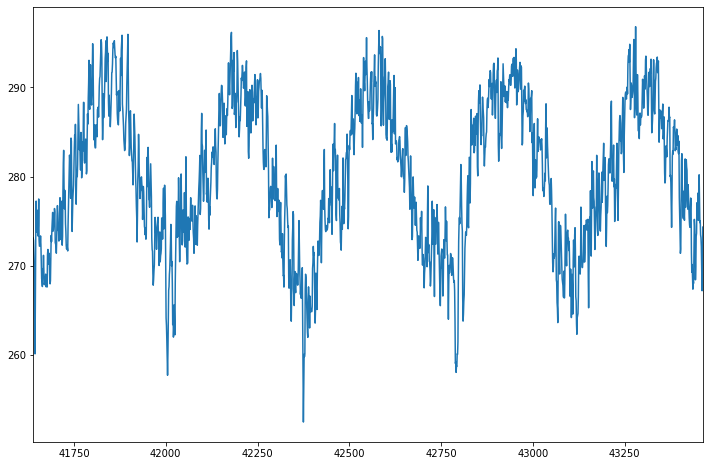

In [78]:
# Original versus counterfactual
# Most visibly, early-spring temperatures are adjusted downwards in this example.
df_with_cfact.loc[last_5_year_start:,"y"].plot(label="original data")
df_with_cfact.loc[last_5_year_start:,"cfact"].plot(label="counterfactual",alpha=0.4)
plt.legend()
plt.ylabel("Temperature")
l = plt.xlabel("Time index")